In [1]:
import rdflib
import networkx as nx
import numpy as np
import random
import pandas as pd
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle



/Users/mariachristina/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
class Node2VecClass:
    
    """
    A class to perform Node2Vec graph embedding and evaluate its effectiveness
    in predicting edges in RDF graphs.

    Attributes:
    -----------
    rdf_files : list of str
        A list of RDF file paths to be combined into a single graph.
    edge_label_mapping : dict
        A dictionary mapping predicates (edge labels) to specific values used in the NetworkX graph.
    param_grid : dict
        A dictionary specifying the grid of parameters for Node2Vec.
    seed : int, optional
        A random seed for reproducibility, default is 42.
    G : networkx.Graph
        The NetworkX graph created from the RDF data.
    train_edges_file : str
        The filename to save or load training edges.
    test_edges_file : str
        The filename to save or load test edges.
    negative_train_edges_file : str
        The filename to save or load negative training edges.
    negative_test_edges_file : str
        The filename to save or load negative test edges.
    results : list
        A list to store results from different parameter configurations.
    best_params : dict or None
        The best parameter set found during evaluation.
    best_accuracy : float or None
        The best accuracy achieved during evaluation.

    Methods:
    --------
    __init__(self, rdf_files, edge_label_mapping, param_grid, seed=42):
        Initializes the Node2VecClass with RDF files, edge label mapping, and parameter grid.

    _load_and_combine_graphs(self):
        Loads RDF files and combines them into a single RDFLib graph.

    _create_networkx_graph(self):
        Converts the combined RDFLib graph into a NetworkX graph using the edge label mapping.

    _prepare_train_test_edges(self):
        Prepares training and testing edges, including negative samples, and saves them to disk.

    train_and_evaluate(self):
        Trains Node2Vec models on the graph with different parameter configurations and evaluates them.

    save_embeddings_with_mapping(self, model, filename, mapping_file):
        Saves the learned embeddings and node-to-index mapping to files.
    """
    
    def __init__(self, rdf_files, edge_label_mapping, param_grid, seed=42):
        
        """
        Initialize the Node2VecClass instance.

        Parameters:
        -----------
        rdf_files : list of str
            A list of RDF file paths to be combined into a single graph.
        edge_label_mapping : dict
            A dictionary mapping predicates (edge labels) to specific values used in the NetworkX graph.
        param_grid : dict
            A dictionary specifying the grid of parameters for Node2Vec.
        seed : int, optional
            A random seed for reproducibility, default is 42.
        """
        
        self.rdf_files = rdf_files
        self.edge_label_mapping = edge_label_mapping
        self.param_grid = param_grid
        self.seed = seed
        self.G = nx.Graph()
        self.train_edges_file = "train_edges.pkl"
        self.test_edges_file = "test_edges.pkl"
        self.negative_train_edges_file = "negative_train_edges.pkl"
        self.negative_test_edges_file = "negative_test_edges.pkl"
        self.results = []
        self.best_params = None
        self.best_accuracy = None
        self._load_and_combine_graphs()
        self._create_networkx_graph()
        self._prepare_train_test_edges()

    def _load_and_combine_graphs(self):
        
        """
        Load RDF files and combine them into a single RDFLib graph.

        This method reads each RDF file, parses it, and adds it to a combined RDFLib graph object.
        """
        
        g_combined = rdflib.Graph()
        for rdf_file in self.rdf_files:
            g = rdflib.Graph()
            g.parse(rdf_file, format="xml")
            g_combined += g
        self.g_combined = g_combined

    def _create_networkx_graph(self):
        
        """
        Convert the combined RDFLib graph into a NetworkX graph.

        This method iterates through the triples in the combined RDFLib graph,
        checks if the predicate is in the edge label mapping, and adds edges 
        to the NetworkX graph accordingly.
        """
        
        for subj, pred, obj in self.g_combined:
            relation = str(pred)
            if relation in self.edge_label_mapping:
                self.G.add_edge(str(subj), str(obj), relation=relation)

    def _prepare_train_test_edges(self):
        
        """
        Prepare training and testing edges, including negative samples.

        This method either loads the edges from previously saved files or generates them by:
        - Splitting the edges into training and testing sets.
        - Generating negative samples by randomly pairing nodes that are not connected.
        - Adding the edge brexpiprazole-alzheimer in the negative test edges on purpose, 
        in order to check if it is predicted.
        - Saving the edges and negative samples.
        """
        
        if os.path.exists(self.train_edges_file) and os.path.exists(self.test_edges_file) and os.path.exists(self.negative_train_edges_file) and os.path.exists(self.negative_test_edges_file):
            with open(self.train_edges_file, 'rb') as f:
                self.train_edges = pickle.load(f)
            with open(self.test_edges_file, 'rb') as f:
                self.test_edges = pickle.load(f)
            with open(self.negative_train_edges_file, 'rb') as f:
                self.negative_train_edges = pickle.load(f)
            with open(self.negative_test_edges_file, 'rb') as f:
                self.negative_test_edges = pickle.load(f)
        else:
            random.seed(self.seed)
            edges = list(self.G.edges())
            self.test_edges = random.sample(edges, int(len(edges) * 0.2))
            self.train_edges = list(set(edges) - set(self.test_edges))

            all_possible_edges = set((u, v) for u in self.G.nodes() for v in self.G.nodes() if u != v)
            existing_edges = set(self.G.edges())
            non_edges = list(all_possible_edges - existing_edges)

            # Add the edge between brexpiprazole and alzheimer to the negative_test_edges
            specific_edge = ('http://erias.fr/oregano/compound/compound_8067', 'http://erias.fr/oregano/disease/disease_145')

            # Ensure the specific edge is in the non_edges list and not in existing_edges
            if specific_edge not in existing_edges and specific_edge in non_edges:
                self.negative_test_edges = random.sample(non_edges, len(self.test_edges) - 1) + [specific_edge]
            else:
                self.negative_test_edges = random.sample(non_edges, len(self.test_edges))

            self.negative_train_edges = random.sample(non_edges, len(self.train_edges))

            with open(self.train_edges_file, 'wb') as f:
                pickle.dump(self.train_edges, f)
            with open(self.test_edges_file, 'wb') as f:
                pickle.dump(self.test_edges, f)
            with open(self.negative_train_edges_file, 'wb') as f:
                pickle.dump(self.negative_train_edges, f)
            with open(self.negative_test_edges_file, 'wb') as f:
                pickle.dump(self.negative_test_edges, f)

        self.train_edges = [(u, v) for u, v in self.train_edges if self.G.has_edge(u, v)]
        self.test_edges = [(u, v) for u, v in self.test_edges if self.G.has_edge(u, v)]
        self.train_graph = self.G.copy()
        self.train_graph.remove_edges_from(self.test_edges)


    def train_and_evaluate(self):
        
        """
        Train Node2Vec models and evaluate their accuracy.

        This method:
        - Iterates through different parameter configurations provided in the param_grid.
        - Trains a Node2Vec model with each configuration.
        - Evaluates the model using logistic regression on the generated edge embeddings.
        - Records the accuracy and finds the best parameter set.
        - Plots the accuracy results based on the Node2Vec parameters.
        """
        
        for params in ParameterGrid(self.param_grid):
            print(f"Testing parameters: {params}")

            node2vec = Node2Vec(
                self.train_graph,
                dimensions=params['dimensions'],
                walk_length=params['walk_length'],
                num_walks=params['num_walks'],
                p=params['p'],
                q=params['q'],
                workers=4
            )
            model = node2vec.fit(window=10, min_count=1, batch_words=4)
            embeddings = model.wv

            def create_edge_embedding(edge):
                return np.concatenate((embeddings[edge[0]], embeddings[edge[1]]))

            X_train = [create_edge_embedding(edge) for edge in self.train_edges] + [create_edge_embedding(edge) for edge in self.negative_train_edges]
            y_train = [1] * len(self.train_edges) + [0] * len(self.negative_train_edges)

            X_test = [create_edge_embedding(edge) for edge in self.test_edges] + [create_edge_embedding(edge) for edge in self.negative_test_edges]
            y_test = [1] * len(self.test_edges) + [0] * len(self.negative_test_edges)

            clf = LogisticRegressionCV(cv=5, max_iter=1000)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            self.results.append((params, accuracy))

            print(f"Accuracy: {accuracy}")

        results_df = pd.DataFrame([{'dimensions': p['dimensions'], 'walk_length': p['walk_length'], 'num_walks': p['num_walks'], 'p': p['p'], 'q': p['q'], 'accuracy': acc} for p, acc in self.results])

        plt.figure(figsize=(12, 6))
        sns.lineplot(data=results_df, x='walk_length', y='accuracy', hue='dimensions', style='num_walks', dashes=False, palette='viridis')
        sns.scatterplot(data=results_df, x='walk_length', y='accuracy', hue='dimensions', style='num_walks', palette='viridis', s=100, legend=False)
        plt.title('Accuracy based on Node2Vec Parameters')
        plt.xlabel('Walk Length')
        plt.ylabel('Accuracy')
        plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

        best_result = results_df.loc[results_df['accuracy'].idxmax()]
        self.best_params = best_result.drop('accuracy').to_dict()
        self.best_accuracy = best_result['accuracy']

        print(f"Best parameters: {self.best_params}")
        print(f"Best accuracy: {self.best_accuracy}")

    def save_embeddings_with_mapping(self, model, filename, mapping_file):
        
        """
        Save the learned node embeddings and their corresponding indices.

        Parameters:
        -----------
        model : gensim.models.Word2Vec
            The trained Node2Vec model containing the embeddings.
        filename : str
            The file name to save the embeddings as a .npy file.
        mapping_file : str
            The file name to save the node-to-index mapping as a .txt file.

        This method extracts the embeddings from the Node2Vec model and saves them to a file.
        It also creates a mapping from nodes to indices and saves this mapping to another file.
        """
        
        embeddings = []
        node_to_idx = {}

        for idx, node in enumerate(self.G.nodes()):
            emb = model.wv[node]
            embeddings.append(emb)
            node_to_idx[node] = idx

        np.save(filename, np.array(embeddings))

        with open(mapping_file, 'w') as f:
            for node, idx in node_to_idx.items():
                f.write(f"{node}\t{idx}\n")

Testing parameters: {'dimensions': 64, 'num_walks': 100, 'p': 1, 'q': 1, 'walk_length': 10}


Computing transition probabilities:   0%|          | 0/2184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Accuracy: 0.8700592885375494
Testing parameters: {'dimensions': 64, 'num_walks': 100, 'p': 1, 'q': 1, 'walk_length': 20}


Computing transition probabilities:   0%|          | 0/2184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


Accuracy: 0.8794466403162056
Testing parameters: {'dimensions': 64, 'num_walks': 100, 'p': 1, 'q': 1, 'walk_length': 30}


Computing transition probabilities:   0%|          | 0/2184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:12<00:00,  1.92it/s]


Accuracy: 0.8893280632411067
Testing parameters: {'dimensions': 64, 'num_walks': 100, 'p': 1, 'q': 1, 'walk_length': 50}


Computing transition probabilities:   0%|          | 0/2184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Accuracy: 0.866600790513834


/Users/mariachristina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mariachristina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


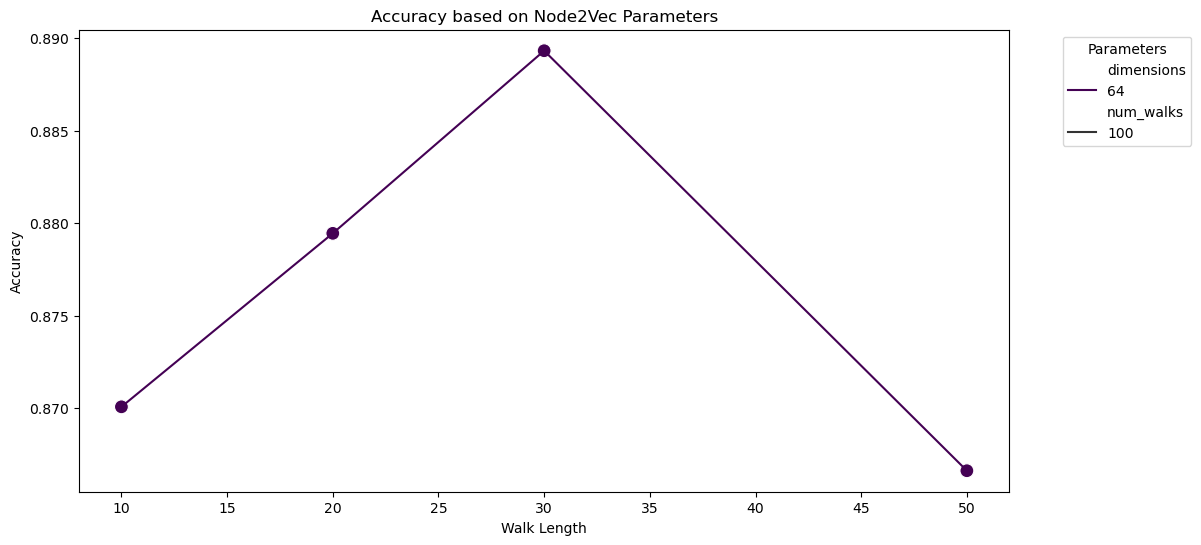

Best parameters: {'dimensions': 64.0, 'walk_length': 30.0, 'num_walks': 100.0, 'p': 1.0, 'q': 1.0}
Best accuracy: 0.8893280632411067


In [3]:
rdf_files = [
    "alzheimer_direct_neighborhood.rdf",
    "depression_direct_neighborhood_only.rdf",
    "urinary_direct_neighborhood_only.rdf",
    "brexpiprazole_direct_neighborhood_only.rdf",
    "cardiovascular_direct_neighborhood.rdf",
    "breast_direct_neighborhood.rdf",
    "ovarian_direct_neighborhood_only.rdf"
]

edge_label_mapping = {
    'http://erias.fr/oregano/#has_effect',
    'http://erias.fr/oregano/#increase_effect',
    'http://erias.fr/oregano/#decrease_effect',
    'http://erias.fr/oregano/#increase_efficacy',
    'http://erias.fr/oregano/#decreases_efficacy',
    'http://erias.fr/oregano/#has_indication',
    'http://erias.fr/oregano/#has_activity',
    'http://erias.fr/oregano/#increase_activity',
    'http://erias.fr/oregano/#decrease_activity',
    'http://erias.fr/oregano/#has_side_effect',
    'http://erias.fr/oregano/#has_target',
    'http://erias.fr/oregano/#is_affecting',
    'http://erias.fr/oregano/#is_substance_that_treats',
    'http://erias.fr/oregano/#acts_within',
    'http://erias.fr/oregano/#causes_condition',
    'http://erias.fr/oregano/#gene_product_of',
    'http://erias.fr/oregano/#has_phenotype'
}

param_grid = {
    'dimensions': [64], 
    'walk_length': [10, 20, 30, 50],
    'num_walks': [100],
    'p': [1],
    'q': [1]
}

model = Node2VecClass(rdf_files, edge_label_mapping, param_grid)
model.train_and_evaluate()


Computing transition probabilities:   0%|          | 0/2184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


Final Model Accuracy: 0.9224308300395256

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1012
           1       0.89      0.96      0.93      1012

    accuracy                           0.92      2024
   macro avg       0.92      0.92      0.92      2024
weighted avg       0.92      0.92      0.92      2024



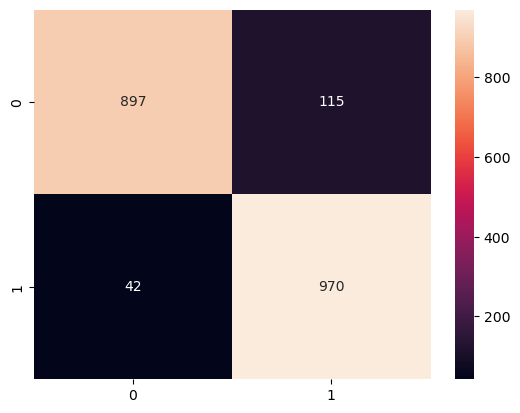

In [4]:
# Train final model with best parameters
node2vec = Node2Vec(
    model.G,
    dimensions=int(model.best_params['dimensions']),
    walk_length=int(model.best_params['walk_length']),
    num_walks=int(model.best_params['num_walks']),
    p=float(model.best_params['p']),
    q=float(model.best_params['q']),
    workers=4
)
final_model = node2vec.fit(
    window=10,
    min_count=1,
    batch_words=4
)
embeddings = final_model.wv

# Function to create edge embeddings
def create_edge_embedding(edge):
    return np.concatenate((embeddings[edge[0]], embeddings[edge[1]]))

# Create train dataset
X_train = [create_edge_embedding(edge) for edge in model.train_edges] + [create_edge_embedding(edge) for edge in model.negative_train_edges]
y_train = [1] * len(model.train_edges) + [0] * len(model.negative_train_edges)

# Create test dataset
X_test = [create_edge_embedding(edge) for edge in model.test_edges] + [create_edge_embedding(edge) for edge in model.negative_test_edges]
y_test = [1] * len(model.test_edges) + [0] * len(model.negative_test_edges)

# Train a logistic regression classifier using cross-validation
clf = LogisticRegressionCV(cv=5, max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities for test edges
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Final Model Accuracy: {accuracy}")

# Store predicted edges in DataFrame
predicted_edges_df = pd.DataFrame({
    'Edge': [f"{edge[0]}-{edge[1]}" for edge in model.test_edges + model.negative_test_edges],
    'Actual Label': y_test,
    'Predicted Label': y_pred,
    'Score': y_pred_proba
})

# Plot classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [5]:
# Save the embeddings and the mapping
model.save_embeddings_with_mapping(final_model, 'node2vec_embeddings_bestParams.npy', 'node_to_idx_bestParams.txt')

In [6]:
# Function to extract the name from the URI
def extract_name(uri):
    return uri.split('/')[-1]

# Store predicted edges in DataFrame
predicted_edges_df = pd.DataFrame({
    'from': [extract_name(edge[0]) for edge in model.test_edges + model.negative_test_edges],
    'to': [extract_name(edge[1]) for edge in model.test_edges + model.negative_test_edges],
    'rel': [model.G.get_edge_data(edge[0], edge[1])['relation'] if edge in model.test_edges else 'None' for edge in model.test_edges + model.negative_test_edges],
    'actual label': y_test,
    'predicted label': y_pred,
    'score': y_pred_proba
})
# predicted_edges_df_list.append(predicted_edges_df)


In [7]:
# predicted_edges_df.tail(20)

In [8]:
# Save the DataFrame to a CSV file
csv_file_path = 'predicted_edges_bestParams.csv'
predicted_edges_df.to_csv(csv_file_path, index=False)

print(f'Results saved to {csv_file_path}')

Results saved to predicted_edges_bestParams.csv


In [9]:
misclassified_edges_df = predicted_edges_df[predicted_edges_df['actual label'] != predicted_edges_df['predicted label']]


In [10]:
misclassified_edges_df

,from,to,rel,actual label,predicted label,score
3,sideeffect_70,compound_14718,http://erias.fr/oregano/#has_side_effect,1,0,0.002022
9,disease_2258,gene_22981,http://erias.fr/oregano/#causes_condition,1,0,0.202000
21,gene_430,disease_1349,http://erias.fr/oregano/#causes_condition,1,0,0.343827
52,gene_16761,disease_500,http://erias.fr/oregano/#causes_condition,1,0,0.246159
74,sideeffect_70,compound_1177,http://erias.fr/oregano/#has_side_effect,1,0,0.003112
...,...,...,...,...,...,...
1971,sideeffect_4364,disease_3200,None,0,1,0.551003
1981,sideeffect_904,disease_681,None,0,1,0.542351
1995,gene_13523,disease_1376,None,0,1,0.750428
2017,sideeffect_1521,disease_1379,None,0,1,0.718398


In [11]:
# False positive edges
false_positive_edges_df = predicted_edges_df[(predicted_edges_df['actual label'] == 0) & (predicted_edges_df['predicted label'] == 1)]

# Sort the misclassified edges in descending order according to score
false_positive_edges_df = false_positive_edges_df.sort_values(by='score', ascending=False)

In [12]:
false_positive_edges_df.head(5)

,from,to,rel,actual label,predicted label,score
1538,disease_1573,gene_4376,None,0,1,0.999789
1521,disease_1952,gene_9705,None,0,1,0.998684
1229,disease_1893,indication_2105,None,0,1,0.997463
2023,compound_8067,disease_145,None,0,1,0.994348
1578,compound_14248,gene_16317,None,0,1,0.994285


In [13]:
false_positive_edges_df.tail(5)

,from,to,rel,actual label,predicted label,score
1182,sideeffect_3069,gene_15253,None,0,1,0.526551
1738,gene_86,sideeffect_795,None,0,1,0.512486
1126,sideeffect_2700,disease_3239,None,0,1,0.512349
1059,disease_2472,gene_10697,None,0,1,0.508898
1606,sideeffect_3571,disease_300,None,0,1,0.507753


In [14]:
# False negative edges
false_negative_edges_df = predicted_edges_df[(predicted_edges_df['actual label'] == 1) & (predicted_edges_df['predicted label'] == 0)]

# Sort the misclassified edges in descending order according to score
false_negative_edges_df = false_negative_edges_df.sort_values(by='score', ascending=False)

In [15]:
false_negative_edges_df.head(20)

,from,to,rel,actual label,predicted label,score
870,compound_1056,protein_3057,http://erias.fr/oregano/#has_target,1,0,0.486833
114,compound_1056,protein_1630,http://erias.fr/oregano/#has_target,1,0,0.485855
291,disease_804,compound_700,http://erias.fr/oregano/#is_substance_that_treats,1,0,0.480446
506,gene_13618,disease_725,http://erias.fr/oregano/#causes_condition,1,0,0.466862
800,compound_1056,protein_6728,http://erias.fr/oregano/#has_target,1,0,0.462304
805,disease_2379,gene_5640,http://erias.fr/oregano/#causes_condition,1,0,0.460384
259,disease_2379,compound_512,http://erias.fr/oregano/#is_substance_that_treats,1,0,0.455335
324,disease_2379,gene_10798,http://erias.fr/oregano/#causes_condition,1,0,0.444841
654,gene_4376,disease_2764,http://erias.fr/oregano/#causes_condition,1,0,0.444335
783,gene_19487,disease_262,http://erias.fr/oregano/#causes_condition,1,0,0.442092
